# (Responsible AI) Entrepreneurship & Innovation

Presented by: Javier Montoya, Dr. sc. ETH
E-Mail: javier.montoya@hslu.ch

---
### PyTorch for Deep Learning Tasks

PyTorch benefits:
* **Easy Interface:** easy to use API with fewer lines of code.
* **Python-ic usage:** it is more python-like programmation and can be seen as NumPy extension to GPUs.
* **Computational graphs:** it offers dynamic computational graphs, that the user can change them during runtime.
* **Wide community**: it is mantained by many developers and offers up-to-date layers, loss functions, etc.



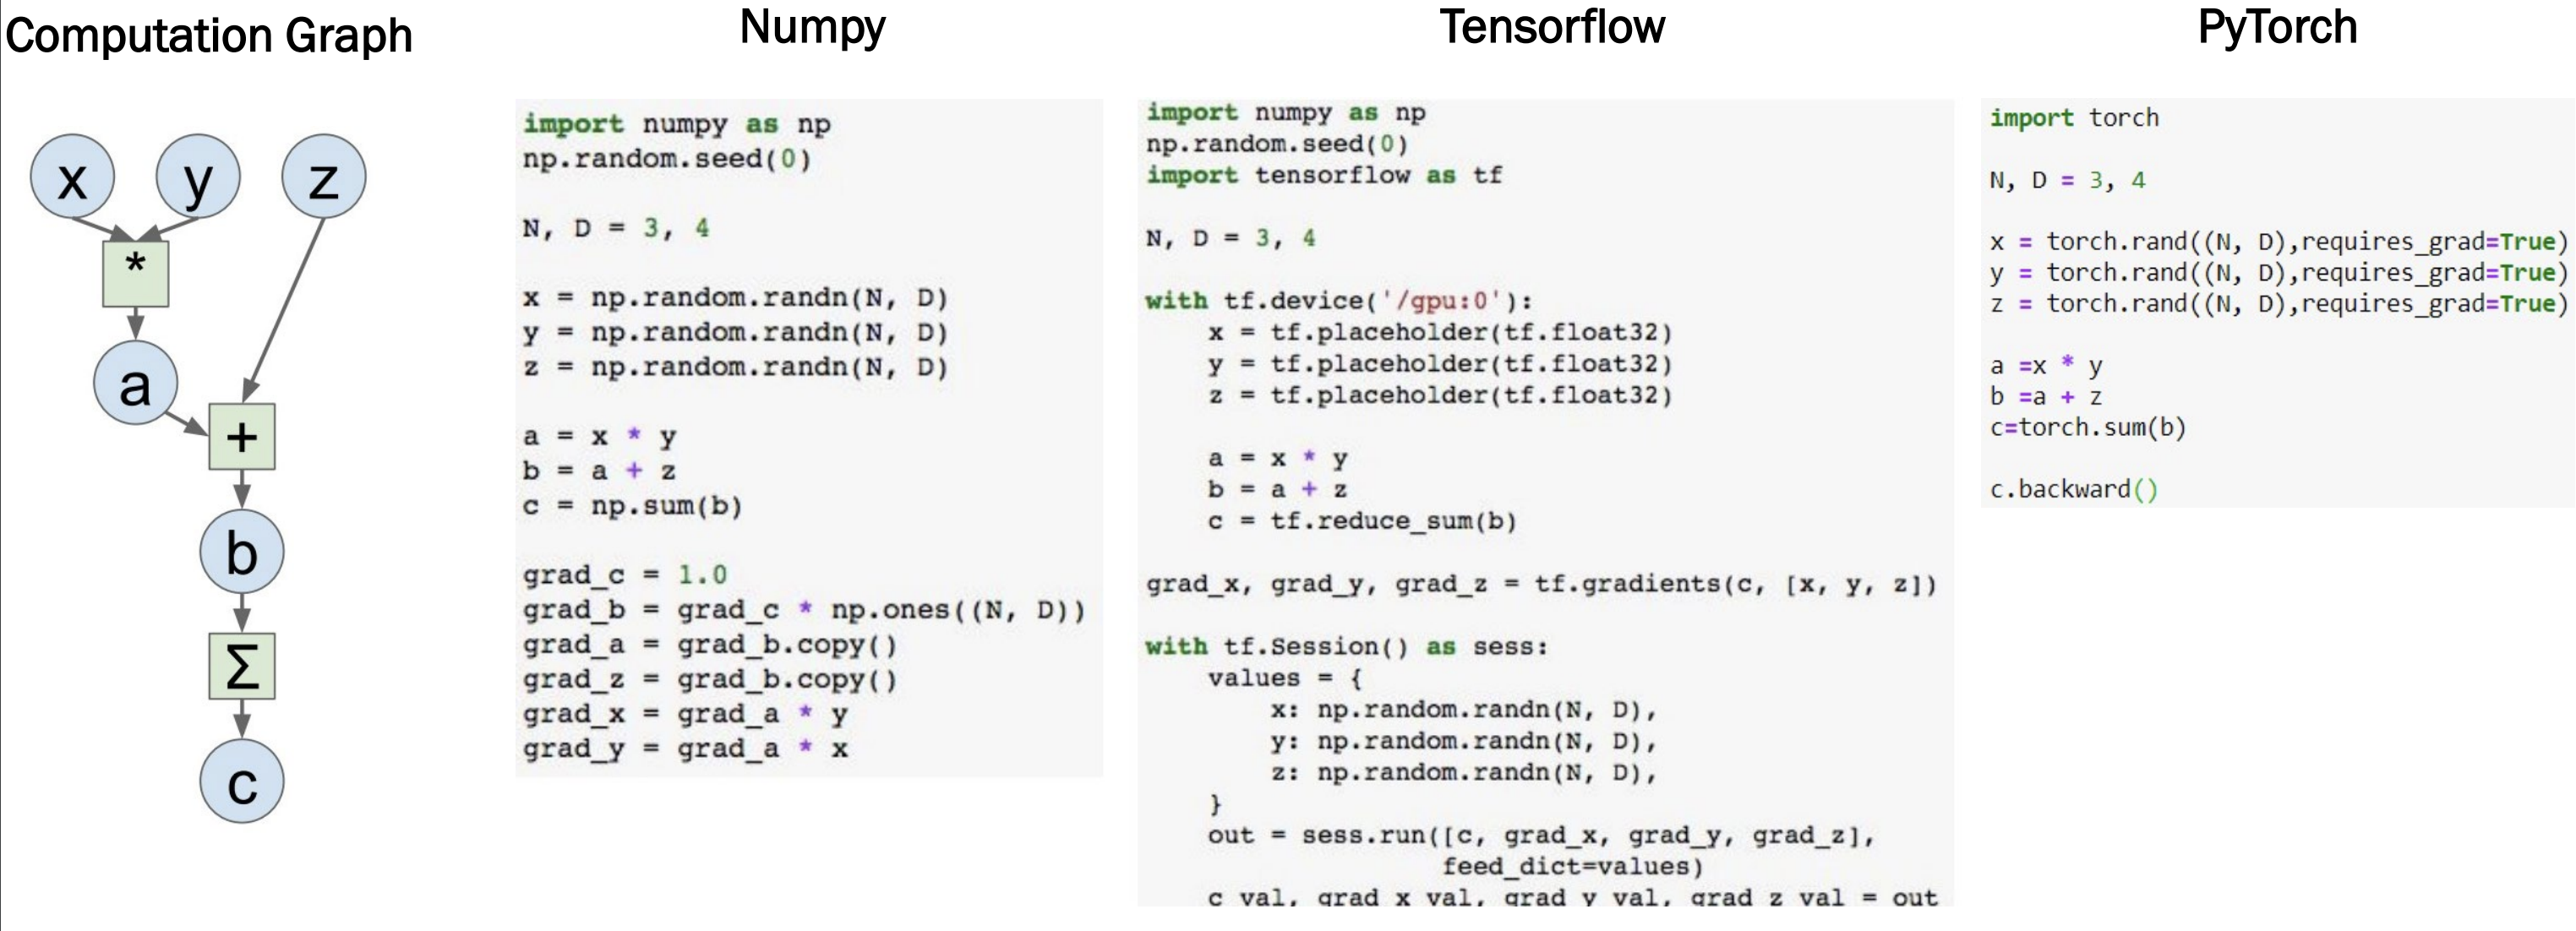

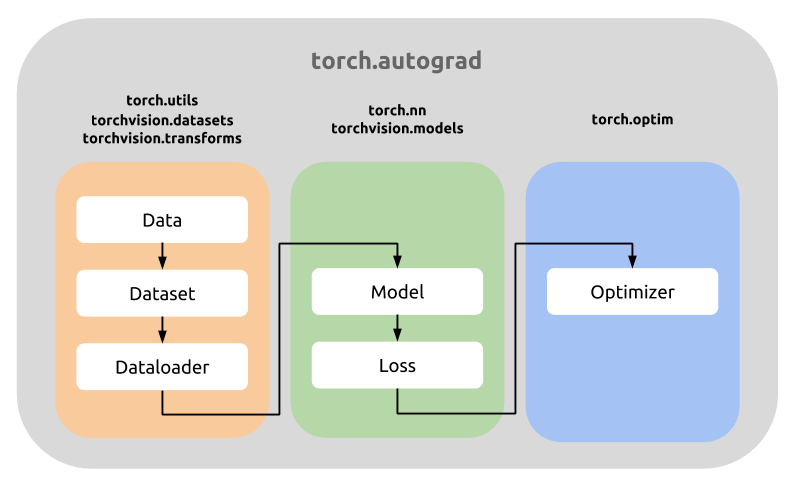

## Project: Feed Forward Neural Network for Digits Classification

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import time
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os as os

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

#### General settings

In [5]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Hyperparameters
random_seed = 1
learning_rate = 0.1
num_epochs = 30

# Architecture
num_features = 28*28
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 10

dataset_dir = 'data'

num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

cuda:0


#### Dataset

In this example, we will use the standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
The MNIST dataset contains of handwritten digits (i.e. 0 to 9) and is used in image classification.

In [6]:
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

# Load the dataset for the training/validation sets
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_valid_dataset = datasets.MNIST(root=dataset_dir, 
                                        train=True,
                                        transform=transforms.ToTensor(), # [0,255] -> [0,1]
                                        download=True)

# 60K images of 28x28 pixels

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
test_dataset = datasets.MNIST(root=dataset_dir, 
                                        train=False,
                                        transform=transforms.ToTensor(), # [0,255] -> [0,1]
                                        download=True)
# 10K images of 28x28 pixels

In [8]:
print('Train dataset size: ', len(train_dataset))
print('Validation dataset size: ', len(valid_dataset))
print('Test dataset size: ', len(test_dataset))

Train dataset size:  48000
Validation dataset size:  12000
Test dataset size:  10000


##### Loading Dataset
**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.

In [9]:
data_loaders = {
    'train': DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_threads),
    'valid': DataLoader(dataset=valid_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_threads),
    'test': DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_threads)
}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print("The train set contains {} images, in {} batches".format(len(data_loaders['train'].dataset), len(data_loaders['train'])))
print("The validation set contains {} images, in {} batches".format(len(data_loaders['valid'].dataset), len(data_loaders['valid'])))
print("The test set contains {} images, in {} batches".format(len(data_loaders['test'].dataset), len(data_loaders['test'])))

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


Visualize some of the training images

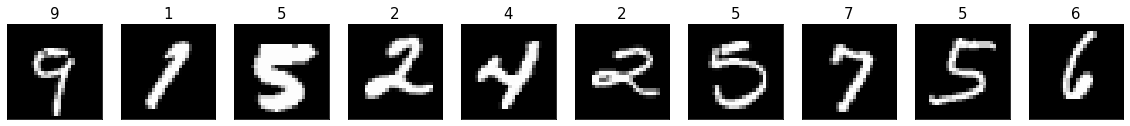

In [10]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(data_loaders['train']))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
print(imgs.shape) # 128 images of 1 channel of 28x28 pixels
print(labels.shape) # 128 labels

torch.Size([128, 1, 28, 28])
torch.Size([128])


Visualize some of the testing images

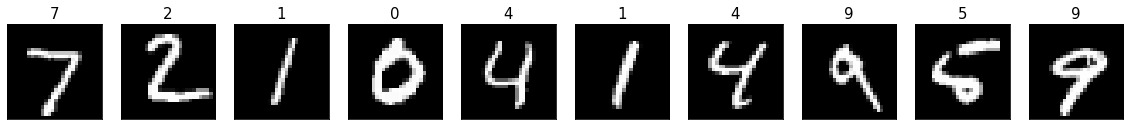

In [11]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(data_loaders['test']))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Visualize some of the testing images

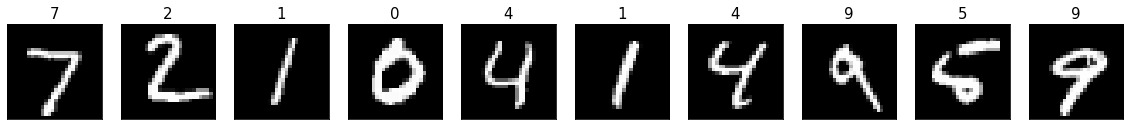

In [12]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(data_loaders['test']))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Model
Whenever we create a neural network in PyTorch, we have to define the `__init__()` and `forward()` methods. PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Our first MLP includes 1x fully-connected layers (i.e. classifier) and is a linear classifier, i.e. we perform logistic regression. As a reminder, in logistic regression, given an input image $x \in \mathbb{R}^{28\times 28}$, we compute scores for each class $k$ as $w_k^T x$, that we pass through the softmax function to get probabilities over the classes :
$$
P(y=k / x) = \frac{e^{w_k^T x}}{\sum_{j=0}^{9} e^{w_j^T x}}
$$

In Pytorch, it is good practice to define class models by subclassing/inheriting from `torch.nn.Module` which provides deep learning methods. Subclassing the Module class usually consists only in redefining the `constructor (init)` and the `forward` method.

In addition, note that by running the forward pass, the input images (x) go through the neural network and generate outputs (logits).

In our MLP, we consider 2x fully-connected layers (i.e. fc1 and classifier). Note that we've a non-linear ReLU layer in between.

In [13]:
class LinearNet(torch.nn.Module):
    def __init__(self, input_size, num_hidden1, num_hidden2, num_classes):
        super(LinearNet, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.num_hidden1 = num_hidden1
        self.num_hidden2 = num_hidden2

        # define 1st hidden/linear layer
        self.fc1 = nn.Linear(in_features=input_size, out_features=num_hidden1)

        # define 2st hidden/linear layer
        self.fc2 = nn.Linear(in_features=num_hidden1, out_features=num_hidden2)

        # define output layer
        self.classifier = nn.Linear(in_features=num_hidden2, out_features=num_classes)

    def forward(self, x):
        z1 = self.fc1(x) # 128 
        a1 = torch.sigmoid(z1) # 128

        z2 = self.fc2(a1) # 256 
        a2 = torch.sigmoid(z2) # 256

        logits = self.classifier(a2) # z3, pre-activation
        probas = torch.softmax(logits, dim=1) # a3, softmax
        return logits, probas # return logits and probas

In [14]:
model = LinearNet(num_features, num_hidden_1, num_hidden_2, num_classes)

In [17]:
model = model.to(device)

In [18]:
print(model)

LinearNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)


### Loss function

Pytorch provides the 
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

For now, back to our experiment, we just need to instantiate the loss :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
```

Alternatively, you can use the [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#nll-loss) function and pass as parameter the result of having applied the `F.log_softmax( )` to your inputs.

In [19]:
loss = torch.nn.CrossEntropyLoss() # define your loss function here

In [20]:
print(loss)

CrossEntropyLoss()


### Optimizer

In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

``` 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # define your optimizer here

In [22]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

#### Train

Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.

In [23]:
def compute_accuracy_and_loss(model, data_loader, device):
    
    correct_pred, num_examples = 0, 0
    
    cross_entropy = 0.

    for ii, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 1*28*28).to(device) # [128,1,28,28] => [128,784]
        targets = targets.to(device) # [128]

        logits, probas = model.forward(features) # forward propagation z=logits, a=f(z)
        cross_entropy += loss(logits, targets)

        _, predicted_labels = torch.max(probas, 1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [24]:
def train(model, num_epochs, train_loader, valid_loader):
  
  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train(True)

      for batch_idx, (features, targets) in enumerate(train_loader):
          
          features = features.view(-1, 1*28*28).to(device) # [128,1,28,28] => [128,784]
          targets = targets.to(device) # [128]

          # forward-propagation
          logits, probas = model.forward(features)

          # compute cost function
          cost = loss(logits, targets)

          # clean gradients
          optimizer.zero_grad()
          
          # compute derivatives
          cost.backward() # partial derivatives over all parameters

          # append minibatch cost
          minibatch_cost.append(cost.item())
          
          # update model parameters
          optimizer.step() # w = w - learning_rate * partial_deriv_error
          
          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost))
              
      with torch.set_grad_enabled(False):
          train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device)
          valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device)

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))
          
          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          if valid_acc > best_acc:
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')

          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [25]:
for p in model.parameters():
    print(p.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [26]:
minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, num_epochs, data_loaders['train'], data_loaders['valid']) # train model

Epoch: 00001/00030 | Batch 00000/00375 | Cost: 2.3439
Epoch: 00001/00030 | Batch 00050/00375 | Cost: 2.3097
Epoch: 00001/00030 | Batch 00100/00375 | Cost: 2.2900
Epoch: 00001/00030 | Batch 00150/00375 | Cost: 2.2901
Epoch: 00001/00030 | Batch 00200/00375 | Cost: 2.3006
Epoch: 00001/00030 | Batch 00250/00375 | Cost: 2.2918
Epoch: 00001/00030 | Batch 00300/00375 | Cost: 2.2636
Epoch: 00001/00030 | Batch 00350/00375 | Cost: 2.2280
Epoch: 00001/00030 | Train cost: 0.0175 | Valid cost: 0.0175 | Train acc.: 21.9937% | Val.acc.: 22.3083%
Better model: saving to disk.
Time elapsed: 0.28 min
Epoch: 00002/00030 | Batch 00000/00375 | Cost: 2.2537
Epoch: 00002/00030 | Batch 00050/00375 | Cost: 2.2031
Epoch: 00002/00030 | Batch 00100/00375 | Cost: 2.1635
Epoch: 00002/00030 | Batch 00150/00375 | Cost: 1.9612
Epoch: 00002/00030 | Batch 00200/00375 | Cost: 1.8905
Epoch: 00002/00030 | Batch 00250/00375 | Cost: 1.6885
Epoch: 00002/00030 | Batch 00300/00375 | Cost: 1.5483
Epoch: 00002/00030 | Batch 00350

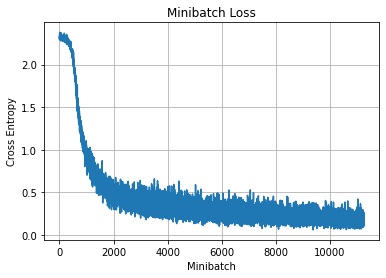

In [27]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.title('Minibatch Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.grid()
plt.show()

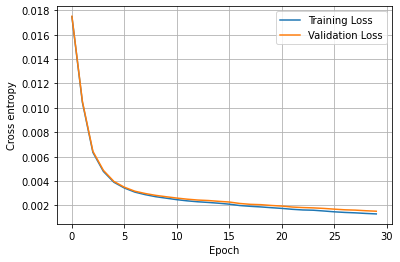

In [62]:
# move the tensors to the CPU
train_loss_tensor = torch.tensor(train_loss_lst).cpu().detach().numpy()
valid_loss_tensor = torch.tensor(valid_loss_lst).cpu().detach().numpy()

plt.plot(range(len(train_loss_tensor)), train_loss_tensor, label='Training Loss')
plt.plot(range(len(valid_loss_tensor)), valid_loss_tensor, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

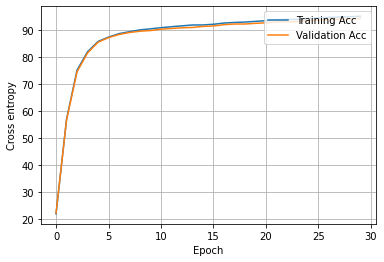

In [61]:
# move the tensors to the CPU
train_acc_tensor = torch.tensor(train_acc_lst).cpu().detach().numpy()
valid_acc_tensor = torch.tensor(valid_acc_lst).cpu().detach().numpy()

plt.plot(range(len(train_acc_tensor)), train_acc_tensor, label='Training Acc')
plt.plot(range(len(valid_acc_tensor)), valid_acc_tensor, label='Validation Acc')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

Once the model has been trained, we can evaluate the model's performance on an **unseen** testing dataset. For that purposes, we are going to use the `compute_accuracy` function together with the `test_loader`.

In [40]:
test_acc, test_loss = compute_accuracy_and_loss(model, data_loaders['test'], device)
print('Test accuracy: %.2f%%' % (test_acc))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test accuracy: 94.92%


In [42]:
# obtain one batch of test images
data_iter = iter(data_loaders['test'])
images, targets = next(data_iter)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
# get sample outputs
features = images.view(-1, 1*28*28).to(device)
logits, probas = model.forward(features)

# convert output probabilities to predicted class
_, preds = torch.max(probas, 1)

In [44]:
targets

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

In [45]:
preds

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 4, 9, 0, 5], device='cuda:0')

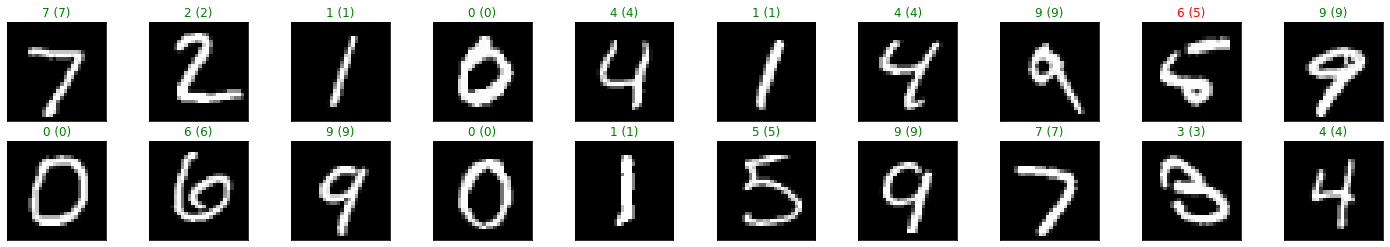

In [47]:
# plot the images in the batch, along with predicted and true targets
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(targets[idx].item())),
                 color=("green" if preds[idx]==targets[idx] else "red"))

In [56]:
# move the tensors to the CPU
targets_tensor = targets.clone().cpu().detach().numpy()
preds_tensor = preds.clone().cpu().detach().numpy()

cm = confusion_matrix(targets_tensor,preds_tensor)

In [57]:
print(cm)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  1  0  0  0]
 [ 0  0  0  0  0  9  1  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  1  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  1  0  0  0  0 16]]


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

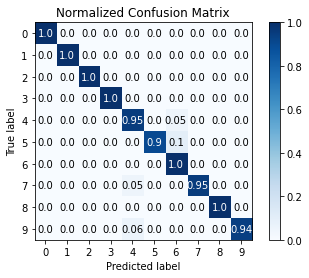

In [58]:
skplt.metrics.plot_confusion_matrix(targets_tensor,preds_tensor, normalize=True)

## Discussion

Multilayer Perceptrons can show some limitations. To summarize some of these issues, we have:

1. Training time: most of the modern neural networks need from hundreds up to thousands of iterations to reach their highest accuracy. This has been a point of criticism, specially because human learning seems to be way more efficient. 
2. Architectural decisions: finding the perfect or an efficient MLP architecture might involve performing many experiments and searching over a large size of hyperparameters. This is mainly because we are trying to solve a non-convex optimisation problem.
3. Biological plausibility of backpropagation: there is no clear evidence that our brain learns via backpropagation, therefore, defining *biologically plausible* models is an on-going research topic.

